# Simple Gaussian Processes

In this notebook, we will reproduce the [celerite2 tutorial](https://celerite2.readthedocs.io/en/latest/tutorials/first/) with emcee.
The goal is to demonstrate how `simple` can be used for models more complicated than [a Gaussian](./getting-started.ipynb) or [a straight line](./fit_line.ipynb).

## Simulated data

This is copied directly from the [celerite2 tutorial](https://celerite2.readthedocs.io/en/latest/tutorials/first/).

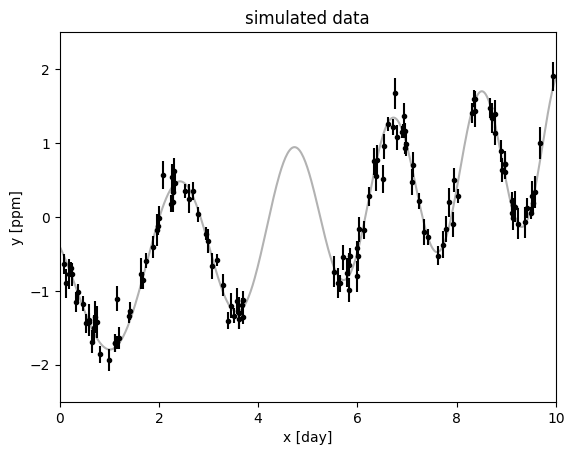

In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

t = np.sort(
    np.append(
        np.random.uniform(0, 3.8, 57),
        np.random.uniform(5.5, 10, 68),
    )
)  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t - 5) + np.sin(3 * t + 0.1 * (t - 5) ** 2) + yerr * np.random.randn(len(t))

true_t = np.linspace(0, 10, 500)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")
plt.show()

## GP Definition

This is also copied from the [celerite2 tutorial](https://celerite2.readthedocs.io/en/latest/tutorials/first/).

In [2]:
from celerite2 import GaussianProcess, terms

# Quasi-periodic term
term1 = terms.SHOTerm(sigma=1.0, rho=1.0, tau=10.0)

# Non-periodic component
term2 = terms.SHOTerm(sigma=1.0, rho=5.0, Q=0.25)
kernel = term1 + term2

# Setup the GP
gp = GaussianProcess(kernel, mean=0.0)
gp.compute(t, yerr=yerr)

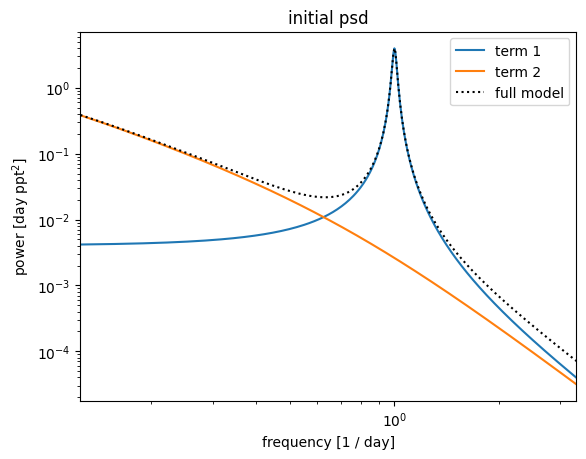

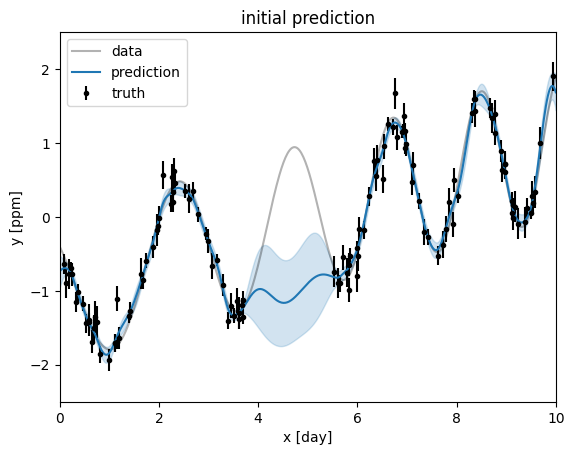

In [3]:
freq = np.linspace(1.0 / 8, 1.0 / 0.3, 500)
omega = 2 * np.pi * freq


def plot_psd(gp):
    for n, term in enumerate(gp.kernel.terms):
        plt.loglog(freq, term.get_psd(omega), label=f"term {n + 1}")
    plt.loglog(freq, gp.kernel.get_psd(omega), ":k", label="full model")
    plt.xlim(freq.min(), freq.max())
    plt.legend()
    plt.xlabel("frequency [1 / day]")
    plt.ylabel("power [day ppt$^2$]")


plt.title("initial psd")
plot_psd(gp)
plt.show()


def plot_prediction(gp):
    plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="data")
    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="truth")

    if gp:
        mu, variance = gp.predict(y, t=true_t, return_var=True)
        sigma = np.sqrt(variance)
        plt.plot(true_t, mu, label="prediction")
        plt.fill_between(true_t, mu - sigma, mu + sigma, color="C0", alpha=0.2)

    plt.xlabel("x [day]")
    plt.ylabel("y [ppm]")
    plt.xlim(0, 10)
    plt.ylim(-2.5, 2.5)
    plt.legend()


plt.title("initial prediction")
plot_prediction(gp)
plt.show()

## Celerite2 model with `simple`

The [celerite2 tutorial](https://celerite2.readthedocs.io/en/latest/tutorials/first/) also defined a `set_params()` function to update the GP parameters before re-computing the likelihood.
Here we modified this function to work with a dictionary instead of an array.

We can then use it inside our `log_likelihood` function that we pass to `simple.Model`.
We use a wide normal prior on all parameters.

In [4]:
from scipy.stats import norm

import simple.model as sm
from simple.distributions import ScipyDistribution


def set_params(params: dict, gp: GaussianProcess, t: np.ndarray, yerr: np.ndarray):
    gp.mean = params["mean"]
    theta = {k: np.exp(v) for k, v in params.items()}
    gp.kernel = terms.SHOTerm(
        sigma=theta["log_sigma_per"], rho=theta["log_rho_per"], tau=theta["log_tau_per"]
    ) + terms.SHOTerm(sigma=theta["log_sigma_non"], rho=theta["log_rho_non"], Q=0.25)
    gp.compute(t, diag=yerr**2 + theta["log_sigma2"], quiet=True)
    return gp


def log_likelihood(
    params: dict, gp: GaussianProcess, t: np.ndarray, y: np.ndarray, yerr: np.ndarray
):
    gp = set_params(params, gp, t, yerr)
    return gp.log_likelihood(y)


prior_dist = norm(0, 2)
parameters = {
    "mean": ScipyDistribution(prior_dist),
    "log_sigma_per": ScipyDistribution(prior_dist),
    "log_rho_per": ScipyDistribution(prior_dist),
    "log_tau_per": ScipyDistribution(prior_dist),
    "log_sigma_non": ScipyDistribution(prior_dist),
    "log_rho_non": ScipyDistribution(prior_dist),
    "log_sigma2": ScipyDistribution(prior_dist),
}

model = sm.Model(parameters, log_likelihood)

## Prior check

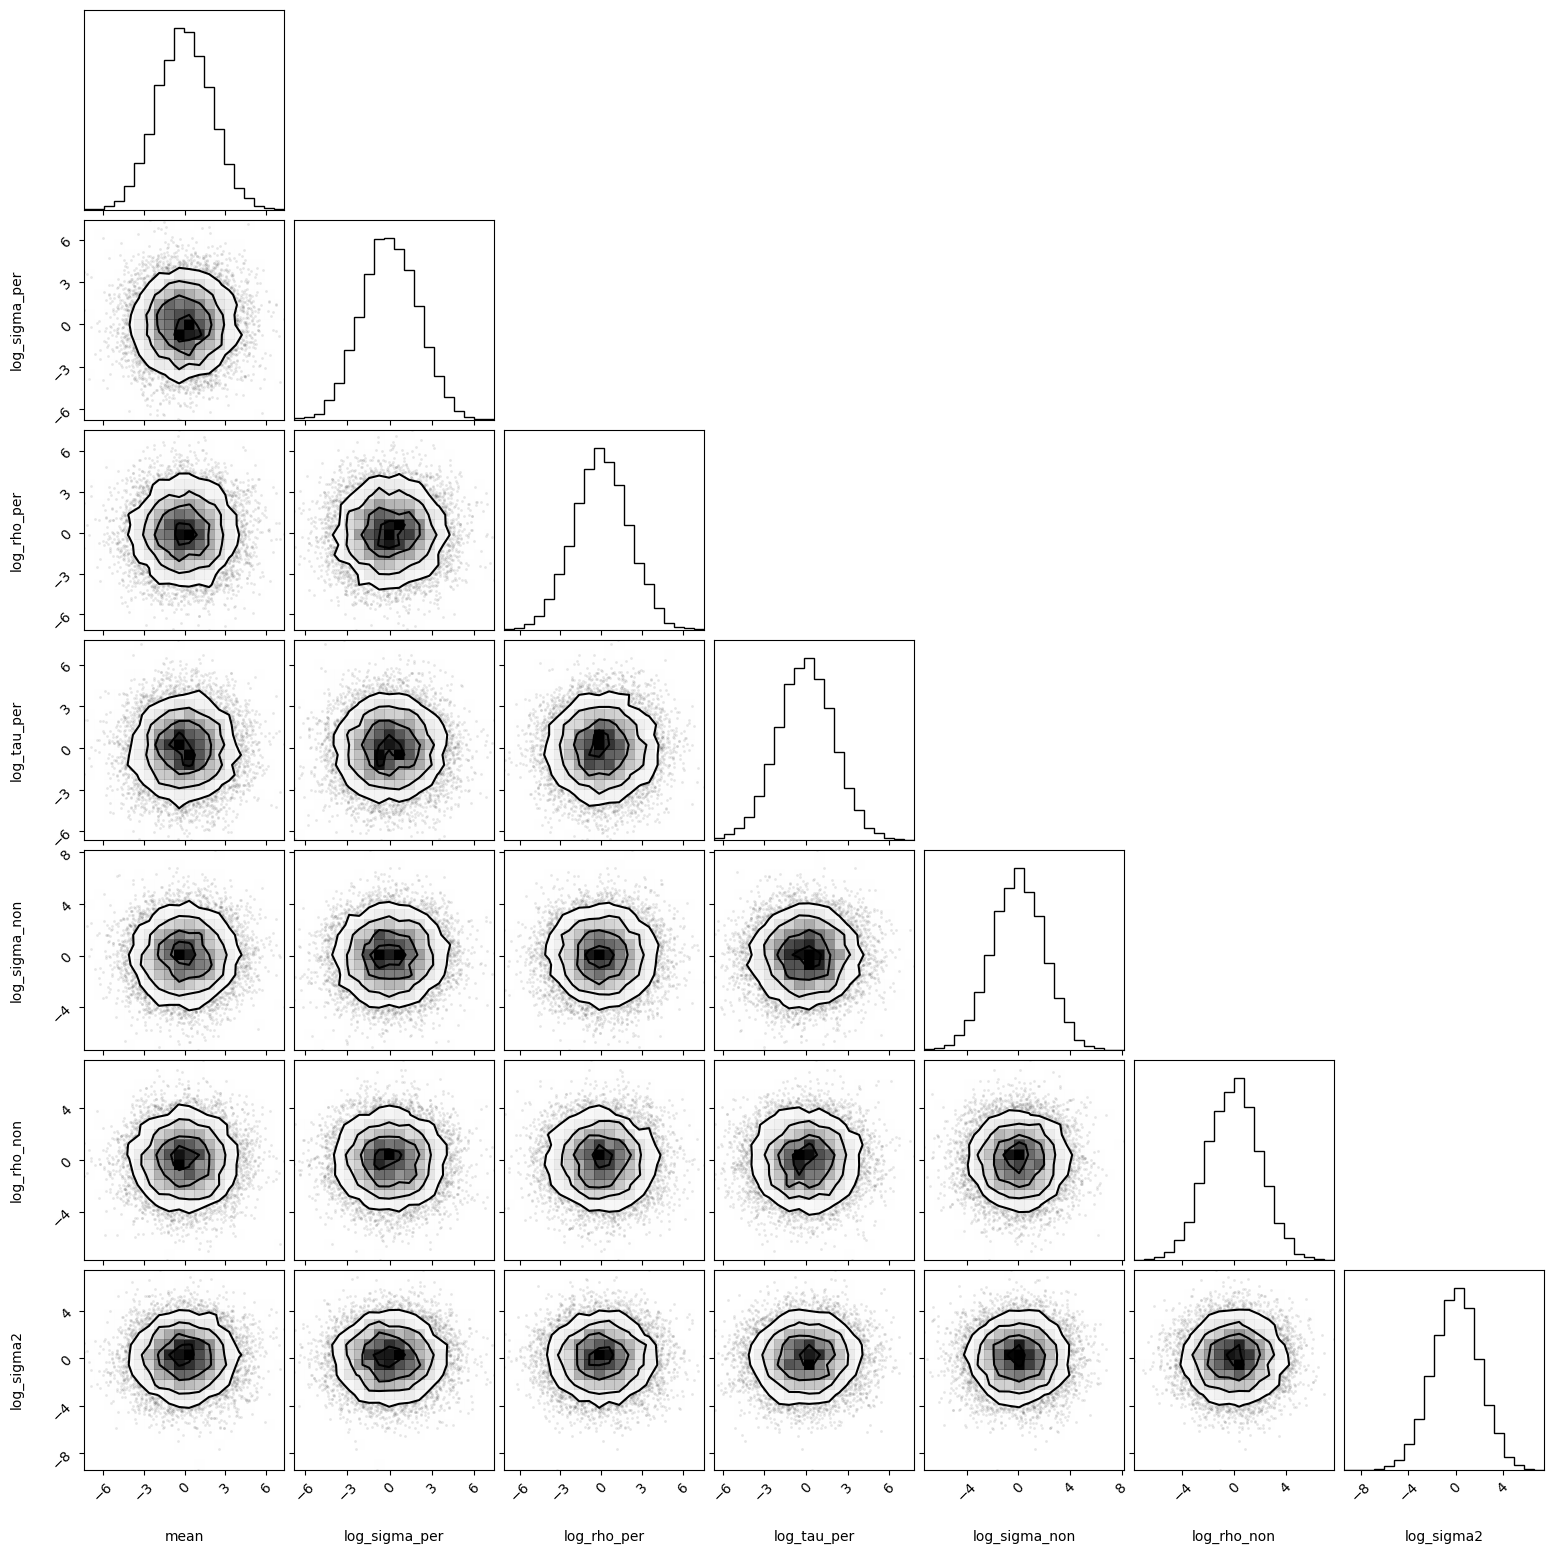

In [5]:
import corner

prior_samples = model.get_prior_samples(10000)
corner.corner(prior_samples)
plt.show()

## Maximum likelihood with scipy

In addition to the sampliong libraries used in previous tutorials, we can use `simple` along with Scipy optimizer.
We only need to adapt the log-likelihood function, either by wrapping it in a `neg_log_likelihood` function or using a `lambda` function, as we do below.

In [6]:
from scipy.optimize import minimize

initial_params = [0.0, 0.0, 0.0, np.log(10.0), 0.0, np.log(5.0), np.log(0.01)]
soln = minimize(
    lambda p: -model.log_likelihood(p, gp, t, y, yerr),
    initial_params,
    method="L-BFGS-B",
)
soln_dict = dict(zip(model.keys(), soln.x, strict=True))
opt_gp = set_params(soln_dict, gp, t, yerr)
soln

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -15.942825677433746
        x: [ 5.230e-03 -3.414e-01  7.000e-01  1.944e+00  6.048e-01
             3.754e+00 -7.872e+00]
      nit: 45
      jac: [ 1.592e-04 -6.096e-04  6.155e-03  9.564e-04 -8.669e-05
            -4.320e-04  5.400e-05]
     nfev: 400
     njev: 50
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>

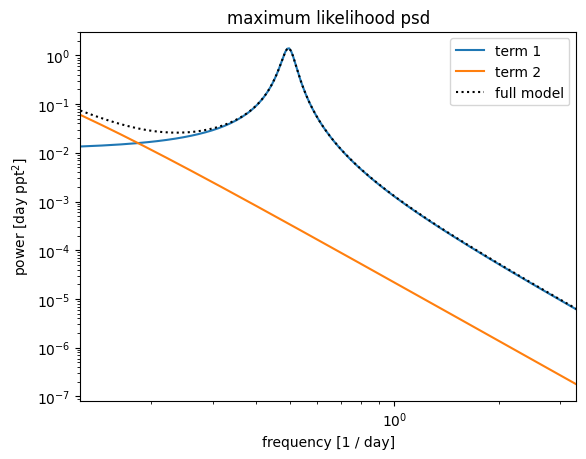

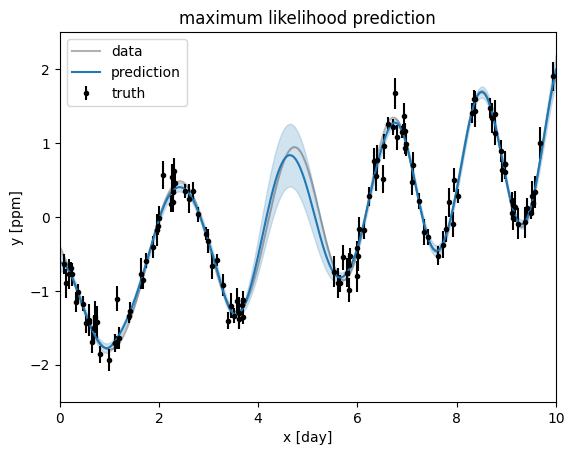

In [7]:
plt.figure()
plt.title("maximum likelihood psd")
plot_psd(opt_gp)
plt.show()

plt.figure()
plt.title("maximum likelihood prediction")
plot_prediction(opt_gp)
plt.show()

## Sampling with emcee

And finally, we can sample the GP model with `emcee`.

In [8]:
import emcee

np.random.seed(5693854)
coords = soln.x + 1e-5 * np.random.randn(32, len(soln.x))
sampler = emcee.EnsembleSampler(
    coords.shape[0], coords.shape[1], model.log_prob, args=(gp, t, y, yerr)
)
sampler.run_mcmc(coords, 7000, progress=True);

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7000/7000 [02:01<00:00, 57.82it/s]


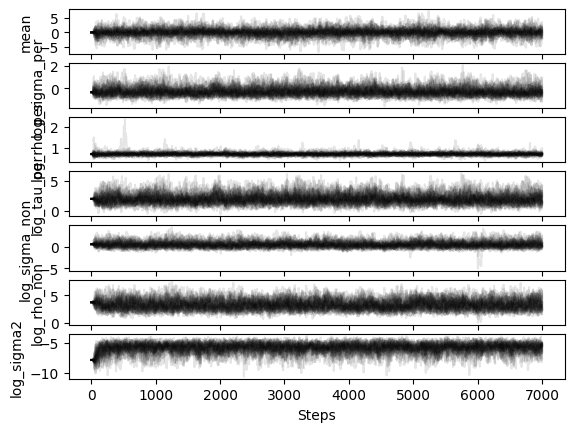

In [9]:
from simple.plot import chainplot

walk_chain = sampler.get_chain()

chainplot(walk_chain, labels=model.keys())
plt.show()

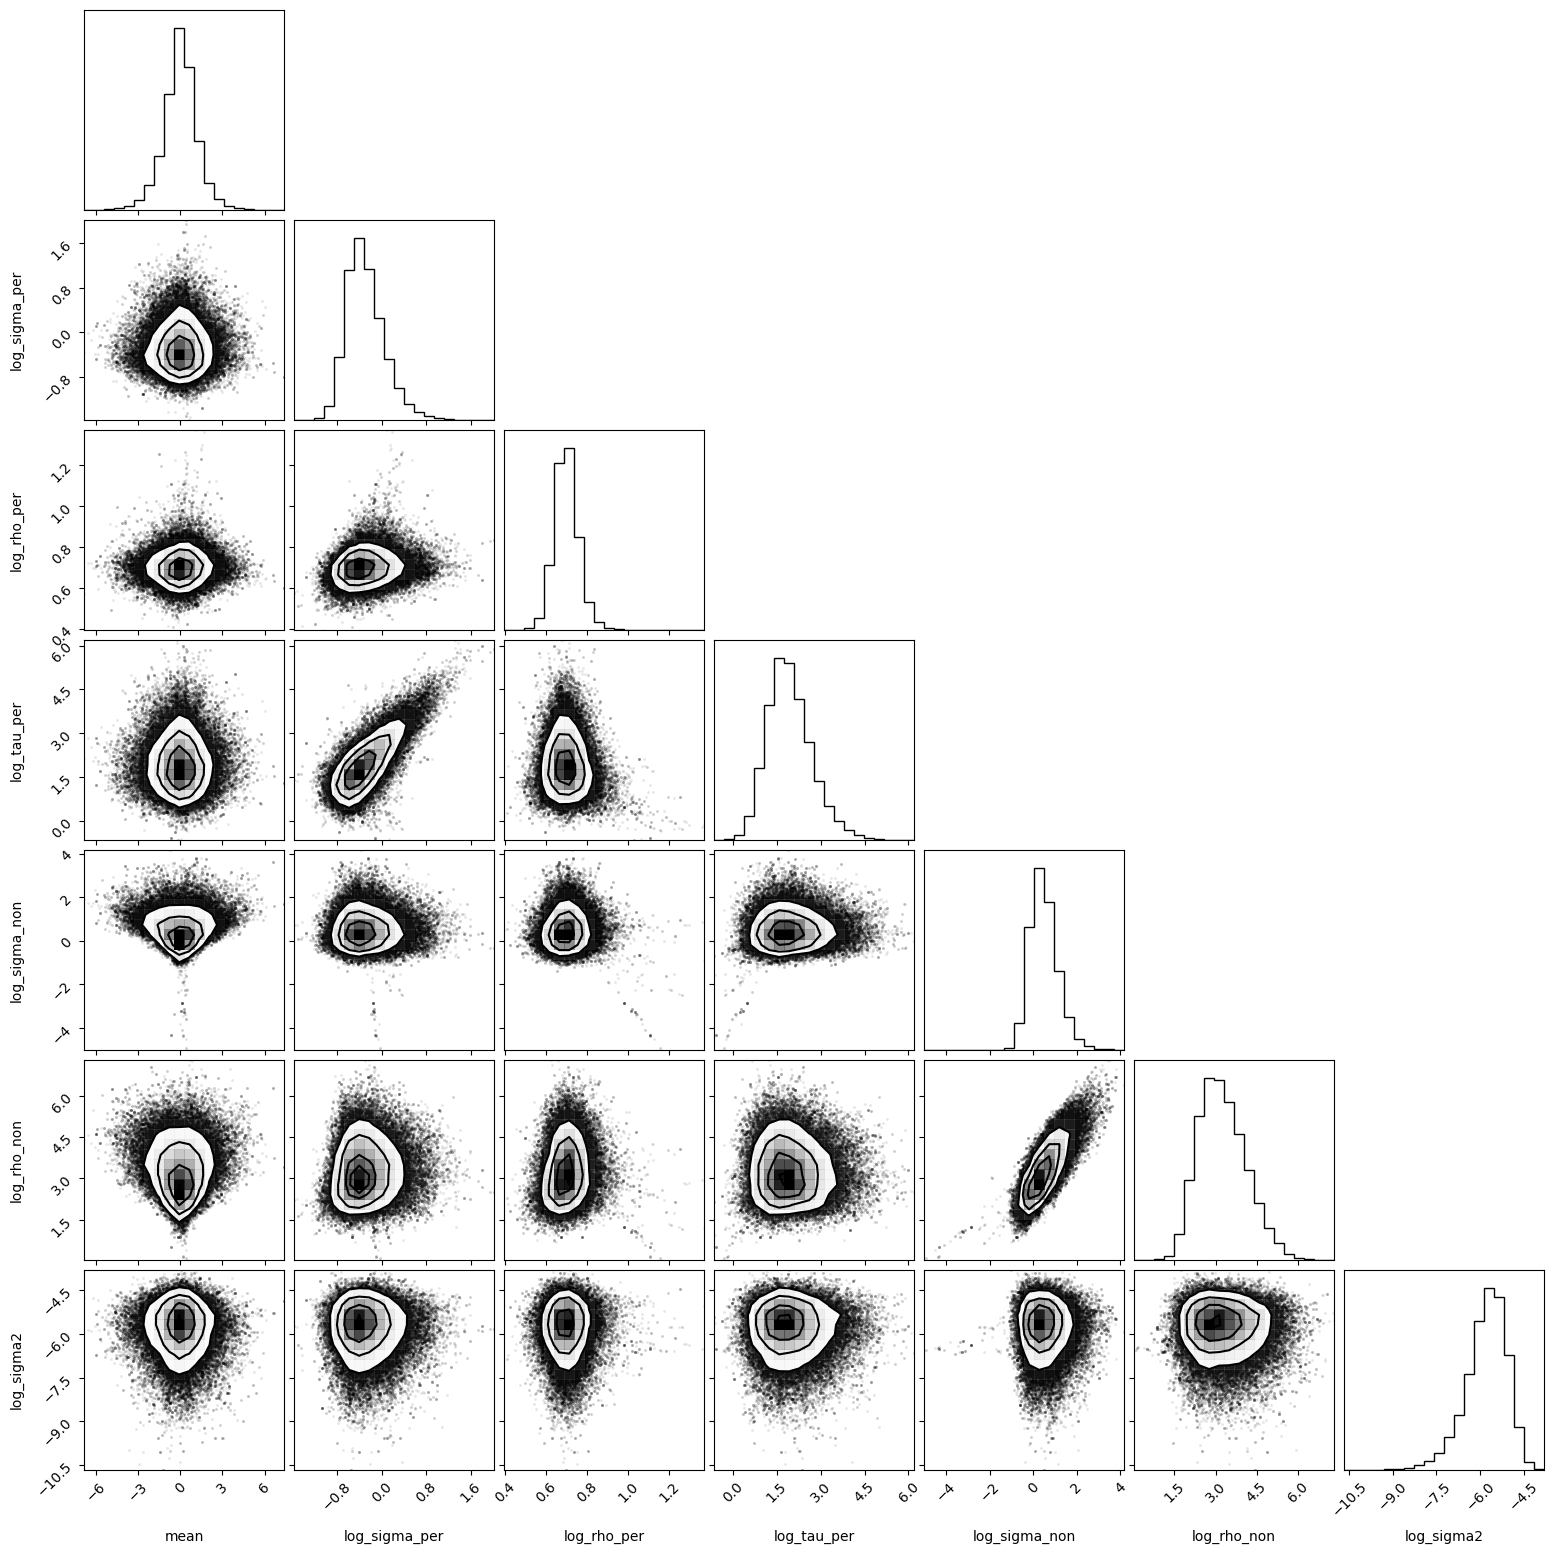

In [10]:
chain = sampler.get_chain(flat=True, discard=2000)

corner.corner(chain, labels=model.keys())
plt.show()

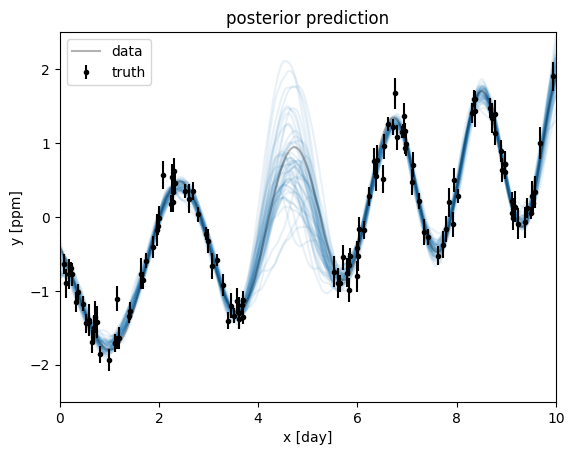

In [11]:
for sample in chain[np.random.randint(len(chain), size=50)]:
    sample_dict = dict(zip(model.keys(), sample, strict=True))
    gp = set_params(sample_dict, gp, t, yerr)
    conditional = gp.condition(y, true_t)
    plt.plot(true_t, conditional.sample(), color="C0", alpha=0.1)

plt.title("posterior prediction")
plot_prediction(None)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160000/160000 [00:35<00:00, 4498.72it/s]


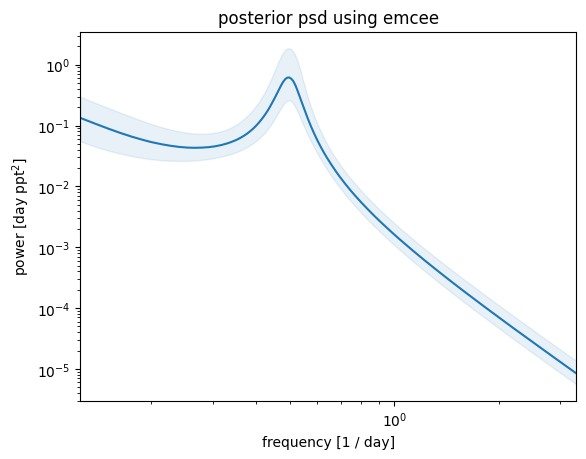

In [12]:
import tqdm

psds = np.empty((chain.shape[0], omega.size))
for i, sample in enumerate(tqdm.tqdm(chain)):
    sample_dict = dict(zip(model.keys(), sample, strict=True))
    gp = set_params(sample_dict, gp, t, yerr)
    psds[i] = gp.kernel.get_psd(omega)

q = np.percentile(psds, [16, 50, 84], axis=0)

plt.loglog(freq, q[1], color="C0")
plt.fill_between(freq, q[0], q[2], color="C0", alpha=0.1)

plt.xlim(freq.min(), freq.max())
plt.xlabel("frequency [1 / day]")
plt.ylabel("power [day ppt$^2$]")
_ = plt.title("posterior psd using emcee")
plt.show()